# Connecting to Facebook API (part 2)

Written by Kat Chuang [@katychuang](http://twitter.com/katychuang)

## Objective

The goal of this exercise is to connect with Facebook Graph Api to collect information about my most recent posts, and also to collect each posts' subsequent comments and likes. This is a continuation from [part 1](http://nbviewer.jupyter.org/github/katychuang/ipython-notebooks/blob/master/facebook_posting_activity.ipynb)

I collected data from my most recent posts and previously saved json output into a `file.json`

In this part we try to plot the data into a chart for visual representation (it's a matplot lib heatmap type of visualization). 

I saved the filename in a separate config file in a separate local folder, `_keys` in a file name `facebook.py`. Inside you want to save a string variable like the following:

```
data_file="XXXXXX"
```


In [1]:
from _keys.facebook import data_file

import json
with open(data_file) as json_data:
    data = json.load(json_data)
    
print (len(data), "posts in this file")

46 posts in this file


From the above code, we read the text file and saved the JSON data to the variable `data` to work with.

We need to pull the time stamps, and their accompanying day of week. We want to convert a list of timestamps into a list of formatted timestamps. But first, we import datetime and parser. 

In [2]:
from datetime import datetime 
from dateutil.parser import parse

# limit to just march posts
march_posts = list(filter(lambda x: parse(x['created_time'][:-5]) >= datetime(2017, 3, 1), data ))
print(len(march_posts), "posts since", datetime(2017, 3, 1).date())

# get days to count occurrence
march_days = list (map( lambda x: parse(x['created_time']).strftime("%A"), march_posts ))

# count number of posts by day of week
for day in march_days: print(day, " \t", march_days.count(day))

21 posts since 2017-03-01
Sunday  	 8
Sunday  	 8
Sunday  	 8
Sunday  	 8
Friday  	 4
Thursday  	 4
Wednesday  	 2
Sunday  	 8
Sunday  	 8
Saturday  	 3
Saturday  	 3
Friday  	 4
Friday  	 4
Friday  	 4
Thursday  	 4
Thursday  	 4
Sunday  	 8
Sunday  	 8
Saturday  	 3
Thursday  	 4
Wednesday  	 2


Now let's write some utility functions to process the data for the chart.

Scrub turns the raw string type into a datetime type. Then we can pass that into dow() and hod() to format the strings. 

In [3]:
def scrub(raw_timestamp):
    timestamp = parser.parse(raw_timestamp)
    return dow(timestamp), hod(timestamp)

# returns day of week
def dow(date): return date.strftime("%A")  # i.e. Monday

# returns hour of day
def hod(time): return time.strftime("%-I:%M%p") # i.e. 

Now we want to try create nested lists. A month contains weeks, which in turn contains days. To express this in code, it would be something like so:

```
M = [W, W, W, ...]
W = ["Mon", "Tues, "Wed", "Thu", ... ]
```

The lists are combined into a list of lists. The 

In [4]:
yIndex = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

# Get a list of week numbers, 0-3. Note that March starts on week 9 of 2017 
# but we subtract 9 to start at index 0
get_week = list (map( lambda x: parse(x['created_time']).isocalendar()[1]-9, march_posts ))

# Get a list of day numbers, 0-6
get_day = list (map( lambda x: yIndex.index(parse(x['created_time']).strftime("%A")), march_posts ))

# create empty array
from itertools import repeat
month = [[0] * 7 for i in repeat(None, 5)]
print(month)

# go thru posts to fill in empty array
for i, (w, d) in enumerate(zip(get_week, get_day)):
    month[w][d] = 1
    
print("active days: \n", month)

[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]
active days: 
 [[0, 0, 1, 1, 0, 1, 1], [0, 0, 0, 1, 1, 1, 1], [0, 0, 1, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]


Now let's step it up and count posts per day, so we can have more than 2 shades of colors on the heatmap.

In [5]:
# empty list of lists
activity = [[0] * 7 for i in repeat(None, 5)]

# the total number of posts
limit = len(get_week)

# fill in empty array with a fraction
for i, (w, d) in enumerate(zip(get_week, get_day)):
    activity[w][d] += 1/limit
    
print("activity per day: \n", activity)

activity per day: 
 [[0, 0, 0.047619047619047616, 0.047619047619047616, 0, 0.047619047619047616, 0.09523809523809523], [0, 0, 0, 0.09523809523809523, 0.14285714285714285, 0.09523809523809523, 0.09523809523809523], [0, 0, 0.047619047619047616, 0.047619047619047616, 0.047619047619047616, 0, 0.19047619047619047], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]


Now our data is ready for plotting. Let's do the important config stuff.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Here's how you create a chart of heatmap type, filled in with values from activity.

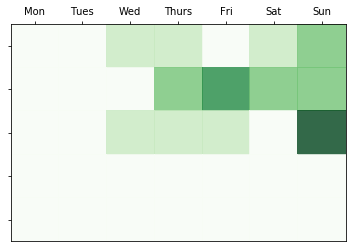

In [9]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(activity, cmap=plt.cm.Greens, alpha=0.8)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(0,7)+0.5, minor=False)
ax.set_yticks(np.arange(0,5)+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# labels
column_labels = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"] 
ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(list(''), minor=False)

plt.show()

I'm not liking how the borders look like. So I'm going to create another version with the seaborn library.

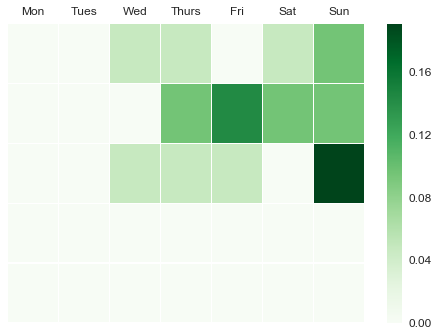

In [10]:
import seaborn as sns

sns.set(font_scale=1.2)
sns.set_style({"savefig.dpi": 100})

ax = sns.heatmap(activity, cmap=plt.cm.Greens, linewidths=.1)

ax.xaxis.tick_top()
ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(list(''), minor=False)

fig = ax.get_figure()